In [1]:
import os
from modules.STRlingExperiment import STRlingExperiment
from modules.EHDNExperiment import EHDNExperiment
import matplotlib

#import circos
import glob
import pandas as pd

from s3_interface import download_tar_files_from_directory, unpack_tar_files
chrom = "chr22"
root_dir = '/scratch/remills_root/remills99/bbessell/str-data/'


In [14]:
import boto3
bucket_name = 'niagads-out-bucket'
bucket_data_dir = '/mnt/data1/out'
s3_client = boto3.client('s3')
response = s3_client.list_objects_v2(Bucket=bucket_name, Prefix=bucket_data_dir)
completed_set = set()
objs = []
if 'Contents' in response:
    for obj in response['Contents']:
        if obj['Key'].endswith('.tar'):
            objs.append(obj["Key"])
print(len(objs))
            

1000


In [2]:
print(sorted(objs))

NameError: name 'objs' is not defined

In [8]:
def extract_subject_from_sample_id(string):
    """
    Extract subject name from NIAGADS location path string.
    """
    subject = "-".join(os.path.basename(string).split("_")[0].split("-")[:3])

    return subject

tests = [
    "G-ADNI-AN000094-BL-NCR-12AD53214___G-ADNI-AN000091-BL-NCR-12AD53145.tar",
    "A-PRHS-PR000345-BL-COL-39213BL1___A-PRHS-PR001430-BL-COL-48986BL1.tar"
]

completed_set = set()

for test in tests:
    if test.endswith('.tar'):
        #subj = extract_subjects(str(obj['Key']))
        sample_ids = str(test).split(".tar")[0].split("___")
        for s in sample_ids:
            subj = extract_subject_from_sample_id(s)
            completed_set.add(subj)
print(completed_set)



{'A-PRHS-PR001430', 'G-ADNI-AN000094', 'A-PRHS-PR000345', 'G-ADNI-AN000091'}


In [ ]:
# get strling calls 
data_dir = os.path.join(root_dir, 'strling-calls')
bucket_name = 'niagads-out-bucket'
bucket_data_dir = '/mnt/data1/out'
download_tar_files_from_directory(bucket_name, bucket_data_dir, data_dir, unpack_directory="output")
unpack_tar_files(data_dir, unpack_directory="output")
directory = os.path.join(data_dir, 'output')
collapsed_directory = os.path.join(root_dir, 'collapsed', 'strling')
genotype_files = glob.glob(os.path.join(collapsed_directory, "*genotype*.txt"))
metadata_file = "ADNI_MIA_PR1066_VAN_StEP_manifest.csv"
chromosomes = ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8',
               'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16',
               'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX', 'chrY']

print(collapsed_directory)
# get strling summary_files
strling_exp = STRlingExperiment(collapsed_directory, metadata_file, chroms=chrom, slop=1000, slop_modifier=5, test="WT")
strling_exp.collapse_sample_tsvs(directory, collapsed_directory)
strling_exp.filter_tsv_files()
strling_summary = strling_exp.summarize_experiment()  # give csv to load instead of calculate
strling_summary = strling_summary.sort_values(['#chrom', 'repeatunit', 'left'], ascending=False)
strling_summary.to_csv(f"results/strling_summary_{chrom}.csv")


In [9]:
# get ehdn calls 
data_dir = os.path.join(root_dir, 'ehdn-calls')
bucket_name = 'niagads-ehdn'
bucket_data_dir = '/mnt/data1/out'
#download_tar_files_from_directory(bucket_name, bucket_data_dir, data_dir)
unpack_tar_files(data_dir)
directory = os.path.join(data_dir, 'output')
collapsed_directory = os.path.join(root_dir, 'collapsed', 'ehdn')
locus_files = glob.glob(os.path.join(directory, "*locus.tsv"))
metadata_file = "ADNI_MIA_PR1066_VAN_StEP_manifest.csv"
#chromosomes = ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8',
#               'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16',
#               'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX', 'chrY']

# get ehdn summary_files
ehdn_exp = EHDNExperiment(collapsed_directory, metadata_file, chroms=chrom, slop=1000, slop_modifier=5, test="WT")
#ehdn_exp.collapse_sample_tsvs(directory, collapsed_directory)
ehdn_exp.filter_tsv_files()
ehdn_summary = ehdn_exp.summarize_experiment()  # give csv to load instead of calculate
ehdn_summary = ehdn_summary.sort_values(['#chrom', 'repeatunit', 'left'], ascending=False)
ehdn_summary.to_csv(f"results/ehdn_summary_{chrom}.csv")


Creating Summary file...
    #chrom         left      right            repeatunit  allele_est  \
0     chr1    8331665.0    8331666         AAAAAATATTTTT          12   
1     chr1   21526622.0   21526623                 AAAAG          33   
2     chr1  207187254.0  207187255                 AAAAG          32   
3     chr1  240082800.0  240082801       AAAATATATATATAT          10   
4     chr1   91839897.0   91839898  AAAATCATGCATGATATTAC          11   
..     ...          ...        ...                   ...         ...   
150   chr1   12062590.0   12062591                  ATCC          43   
151   chr1   22333804.0   22333805                  ATCC          39   
152   chr1   24266306.0   24266307                  ATCC          39   
153   chr1   31545875.0   31545876                  ATCC          41   
154   chr1  182761863.0  182761864  CCCCCCCCCCCCCCCCCCCG           7   

     merged_expansions  
0                False  
1                False  
2                False  
3         

In [ ]:
# merge pkl files for EHDN-LDRN
# python merge_lrdn_output.py lrdn_output_dir/ lrdn_output.tsv
# get pkl files from ehdn directory and put in new directory
# firs make new directory
os.mkdir(os.path.join(root_dir, 'merged', 'ehdn-ldrn'))
# then copy pkl files from directory and put in new directory
import shutil
import glob
src = os.path.join(data_dir, 'output')
dst = os.path.join(root_dir, 'merged', 'ehdn-ldrn')
files = glob.glob(os.path.join(src, "*.pkl"))
for f in files:
    shutil.copy(f, dst)

# then run the merge
import sys
ehdn_path = "/home/bbessell/tibanna-scheduler/ExpansionHunterDenovo-LRDN/merge_lrdn_output.py"
# execute the script
tsv_path = os.path.join(root_dir, 'merged', 'ehdn-ldrn', 'ehdn-ldrn-merged.tsv')
!python {ehdn_path} {dst} {tsv_path}



In [19]:
# process strling variants and run ranksum tests
strling_summary = pd.read_csv(f"results/strling_summary_{chrom}.csv")
strling_summary_filt = strling_summary[strling_summary["counts"] > 50]
del strling_summary
print(strling_summary_filt.head())
strling_WT_df = strling_exp.perform_stat_test(strling_summary_filt)
strling_WT_df.sort_values(['p_value'], ascending=True, inplace=True)
strling_WT_df.to_csv(f"results/strling_{strling_exp.test}_df_{chrom}.csv")
strling_WT_df = pd.read_csv(f"results/strling_{strling_exp.test}_df_{chrom}.csv")
strling_WT_df.iloc[:12,]

    Unnamed: 0 #chrom          left repeatunit  counts  variance_left  \
9          630   chr5  1.516128e+08         GT  1578.0       2.858974   
11         628   chr5  1.458212e+08         GT   191.0       0.401092   
26         613   chr5  5.586724e+07         GT   255.0      71.041868   
30         609   chr5  3.413206e+06         GT   216.0       0.708706   
33         606   chr5  9.837533e+05         GT  1578.0       2.227264   

       mean_left            m2  
9   1.516128e+08   4508.601514  
11  1.458212e+08     76.207467  
26  5.586724e+07  18044.634383  
30  3.413206e+06    152.371798  
33  9.837533e+05   3512.396027  


,Unnamed: 0,chrom,mean_left,std_dev,variant,statistic,p_value,case_values,control_values,recovered_variants,actual_variants,warning,multi_expansions,p_corrected,reject_null
0,76,chr5,1.248989e+08,4.770234,AT,-8.634684,5.888974e-18,"[0, 0, 0, 216.27, 301.04, 0, 132.37, 139.23, 1...","[0, 159.31, 0, 215.31, 0, 0, 180.3, 0, 218.06,...",985,985.0,False,0,1.213129e-15,True
1,85,chr5,1.267397e+08,1.996365,AT,-8.368354,5.842863e-17,"[0, 0, 0, 170.89, 94.98, 0, 54.32, 118.31, 85....","[0, 85.36, 0, 67.85, 0, 69.06, 114.68, 148.27,...",757,757.0,True,1,6.018149e-15,True
2,148,chr5,1.708340e+08,1.382167,ACC,8.236057,1.779787e-16,"[54.66, 49.94, 44.72, 0, 0, 47.74, 0, 0, 0, 38...","[47.59, 0, 53.84, 0, 50.61, 0, 0, 0, 0, 59.13,...",733,733.0,False,0,1.222120e-14,True
3,79,chr5,1.526974e+08,2.168358,AT,-8.197914,2.445938e-16,"[0, 0, 0, 187.97, 184.39, 0, 156.98, 190.34, 1...","[152.59, 216.69, 0, 217.72, 0, 0, 215.48, 222....",943,941.0,True,17,1.259658e-14,True
4,112,chr5,5.600762e+07,0.700240,AT,-7.864092,3.717845e-15,"[0, 154.8, 159.82, 229.7, 220.13, 84.77, 188.1...","[162.94, 262.63, 163.64, 203.5, 134.72, 116.89...",1537,1537.0,False,0,1.531752e-13,True
5,93,chr5,1.190632e+08,0.654428,AT,-7.741093,9.856581e-15,"[0, 0, 0, 185.29, 192.77, 0, 0, 102.0, 132.2, ...","[0, 74.12, 0, 151.41, 0, 70.19, 82.92, 107.12,...",732,732.0,False,0,3.384093e-13,True
6,114,chr5,4.065177e+07,1.695466,AT,-7.279399,3.353112e-13,"[0, 0, 0, 129.9, 96.51, 0, 0, 85.78, 103.5, 0,...","[0, 79.68, 0, 111.6, 0, 65.87, 102.74, 81.42, ...",718,718.0,False,0,9.867729e-12,True
7,99,chr5,1.075919e+08,1.550239,AT,-7.079946,1.442111e-12,"[0, 0, 0, 113.57, 156.33, 0, 58.14, 69.38, 62....","[0, 85.42, 0, 136.61, 0, 69.51, 104.03, 0, 102...",826,826.0,False,0,3.713437e-11,True
8,90,chr5,9.823185e+07,2.432468,AT,-6.746571,1.513797e-11,"[0, 0, 0, 90.14, 146.15, 0, 65.48, 111.71, 109...","[0, 91.29, 0, 109.64, 0, 0, 68.36, 89.89, 137....",856,856.0,False,0,3.464913e-10,True
9,95,chr5,8.725797e+07,4.886475,AT,-6.686472,2.286147e-11,"[0, 0, 0, 99.25, 72.69, 0, 66.94, 0, 75.14, 0,...","[0, 95.98, 0, 60.58, 0, 0, 0, 104.72, 118.18, ...",708,708.0,False,0,4.709463e-10,True


In [10]:
# process strling variants and run ranksum tests
ehdn_summary = pd.read_csv(f"results/ehdn_summary_{chrom}.csv")
ehdn_summary_filt = ehdn_summary[ehdn_summary["counts"] > 50]
del ehdn_summary
print(ehdn_summary_filt.head())
ehdn_WT_df = ehdn_exp.perform_stat_test(ehdn_summary_filt)
ehdn_WT_df.sort_values(['p_value'], ascending=True, inplace=True)
ehdn_WT_df.to_csv(f"results/ehdn_{ehdn_exp.test}_df_{chrom}.csv")
ehdn_WT_df = pd.read_csv(f"results/ehdn_{ehdn_exp.test}_df_{chrom}.csv")
ehdn_WT_df.iloc[:12,]

       Unnamed: 0 #chrom          left            repeatunit  counts  \
42         184170   chr1  1.324256e+06              CCCCCCCG    86.0   
654        183558   chr1  1.035258e+08     CCCCCCCCCCCCCCGCG    53.0   
20488      163724   chr1  1.428201e+06  CCCCCCCCCCCCCCCCCCCG    55.0   
20529      163683   chr1  1.115653e+06  CCCCCCCCCCCCCCCCCCCG    99.0   
20576      163636   chr1  2.454352e+08                  ATCC   173.0   

       variance_left     mean_left             m2  
42          2.736648  1.324256e+06     232.615048  
654        70.296109  1.035258e+08    3655.397681  
20488    5261.329636  1.428201e+06  284111.800357  
20529    5395.136461  1.115653e+06  528723.373181  
20576      57.009522  2.454352e+08    9805.637819  


,Unnamed: 0,chrom,mean_left,std_dev,variant,statistic,p_value,case_values,control_values,recovered_variants,actual_variants,warning,multi_expansions,p_corrected,reject_null
0,128,chr1,1.906131e+07,1.461610,ACC,8.142084,3.885305e-16,"[66, 75, 52, 63, 57, 80, 52, 57, 75, 104, 55, ...","[71, 0, 0, 0, 69, 54, 0, 80, 76, 52, 0, 0, 0, ...",1041,1041.0,False,0,1.464760e-13,True
1,125,chr1,2.955321e+07,25.349627,ACC,8.031273,9.646606e-16,"[144, 143, 62, 114, 147, 140, 116, 59, 152, 12...","[165, 144, 122, 115, 164, 118, 67, 149, 176, 6...",1500,1494.0,False,0,1.818385e-13,True
2,123,chr1,1.101202e+08,3.630428,ACC,7.653364,1.957882e-14,"[101, 91, 64, 92, 103, 88, 69, 74, 89, 56, 57,...","[81, 71, 64, 52, 93, 66, 0, 63, 102, 64, 52, 5...",1455,1455.0,False,0,1.890718e-12,True
3,122,chr1,4.154478e+07,3.226420,ACC,7.650239,2.006067e-14,"[162, 125, 56, 135, 112, 147, 62, 54, 148, 56,...","[143, 109, 52, 54, 203, 104, 72, 108, 203, 54,...",1402,1399.0,True,3,1.890718e-12,True
4,114,chr1,2.972335e+07,12.594687,ACC,6.929171,4.233128e-12,"[73, 75, 58, 81, 83, 98, 54, 0, 84, 52, 107, 8...","[107, 61, 0, 54, 82, 106, 52, 87, 140, 0, 58, ...",1290,1287.0,True,1,3.191779e-10,True
5,13,chr1,3.588565e+06,0.149755,AGGAGGGGGC,6.518105,7.120125e-11,"[22, 19, 0, 16, 18, 19, 0, 0, 20, 0, 15, 22, 2...","[18, 0, 15, 15, 21, 0, 0, 21, 27, 15, 0, 0, 0,...",618,618.0,False,0,4.473812e-09,True
6,130,chr1,3.065519e+07,4.559772,ACC,6.438551,1.206191e-10,"[101, 98, 78, 156, 131, 134, 67, 62, 118, 115,...","[147, 123, 64, 54, 131, 112, 110, 137, 146, 59...",1493,1492.0,True,4,6.496200e-09,True
7,184,chr1,2.010074e+08,16.357173,AC,6.415323,1.405248e-10,"[89, 89, 0, 84, 161, 84, 0, 0, 85, 78, 0, 88, ...","[78, 89, 0, 78, 107, 0, 0, 82, 90, 0, 79, 82, ...",708,708.0,False,0,6.622229e-09,True
8,100,chr1,1.202075e+06,18.240396,ACCCAGCCCCCAGCCCAGT,6.191556,5.957316e-10,"[17, 8, 16, 17, 10, 24, 0, 16, 17, 8, 16, 20, ...","[19, 9, 16, 8, 16, 8, 8, 19, 19, 18, 16, 17, 1...",1369,1366.0,False,0,2.495454e-08,True
9,126,chr1,4.774318e+07,8.983226,ACC,6.173782,6.667540e-10,"[55, 0, 0, 56, 54, 54, 54, 0, 57, 0, 0, 61, 57...","[54, 0, 0, 52, 58, 52, 0, 61, 68, 0, 0, 0, 0, ...",561,559.0,True,3,2.513663e-08,True


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def create_split_violin_plots(WT_df):
    # Filter DataFrame for variants with p-value < 0.3
    filtered_df = WT_df[WT_df['p_value'] < 0.2]
    
    # Calculate the number of rows and columns for the grid
    num_plots = len(filtered_df)
    num_cols = min(num_plots, 5)
    num_rows = math.ceil(num_plots / num_cols)
    
    print(f"{num_plots} variants to plot.")

    for i, row in filtered_df.iterrows():
        if type(row['case_values']) == str:
            case_values = [float(x) for x in row['case_values'].strip('[').strip(']').split(',')]
            control_values = [float(x) for x in row['control_values'].strip('[').strip(']').split(',')]
        else:
            case_values = row['case_values']
            control_values = row['control_values']
            
        print(row)
        avg_case = np.mean(case_values)
        avg_cont = np.mean(control_values)
        case_nozeros = [val for val in case_values if val>0]
        cont_nozeros = [val for val in control_values if val>0]

        print(f"case avg (nonzero): {avg_case} ({np.mean(case_nozeros)})")
        print(f"cont avg (nonzero): {avg_cont} ({np.mean(cont_nozeros)})")
        
        # Calculate normalized heights
        case_height = len(case_values) / len(row['case_values'])
        control_height = len(control_values) / len(row['control_values'])
        
        # Normalize values by sample size
        #case_values_normalized = [x / row['case_sample_size'] for x in case_values]
        #control_values_normalized = [x / row['control_sample_size'] for x in control_values]

        # Create a figure and axes for the plot
        fig, ax = plt.subplots()

        # Plot split violin plots for case and control values
        #sns.violinplot(data=[control_values, case_values], split=True, ax=ax, scale={"width": "count", "area": control_height + case_height})
        
        # Manually plot violins with adjusted heights
        #ax.violinplot([control_values], positions=[0], widths=0.8, vert=False, showmeans=False, showmedians=False)
        #ax.violinplot([case_values], positions=[1], widths=0.8, vert=False, showmeans=False, showmedians=False)
        
        # no scaling
        ax.violinplot([control_values], positions=[0], widths=0.8, vert=False, showmeans=True, showmedians=False)
        ax.violinplot([case_values], positions=[1], widths=0.8, vert=False, showmeans=True, showmedians=False)
        
        # Set labels and title for the plot
        #ax.set_xlabel('Control vs Case')
        #ax.set_ylabel('Normalized Allele 2 Size')
        #ax.set_title(f"Repeat Unit: {row['variant']} on {row['chrom']} ({row['effect']} effect)")
        
        # Set labels and title for the plot
        ax.set_yticks([0, 1])
        ax.set_yticklabels(['Control', 'Case'])
        ax.set_xlabel('Allele 2 Size')
        ax.set_title(f"Repeat Unit: {row['variant']} on {row['chrom']} ({row['statistic']} statistic)")

        # Adjust opacity of the violins
        for collection in ax.collections:
            collection.set_alpha(0.6)
        
        # Show the plot
        plt.show()


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

def rev_complement(motif):
        rev_dict = {
            "A": "T",
            "T": "A",
            "C": "G",
            "G": "C"
        }
        return [rev_dict[base] for base in motif[::-1]]
    
def is_rotation(str1, str2):
    """
    Checks if string is a rotation of another
    """
    if len(str1) != len(str2):
        return False

    if str1 == str2:
        return True

    # to handle idexing in circular rotation
    concat = str1 + str1
    n = len(concat)

    # make prefix table as per Knuth-Morris-Pratt (KMP) algorithm
    prefix = [0] * n
    j = 0
    for i in range(1, n):
        if concat[i] == concat[j]:
            j += 1
            prefix[i] = j
        else:
            if j > 0:
                j = prefix[j-1]
                i -= 1
            else:
                prefix[i] = 0

    # Check if string 2 is a substring in the concatenated string with prefix table
    j = 0
    for i in range(n):
        if concat[i] == str2[j]:
            j += 1
            if j == len(str2):
                return True
        else:
            if j > 0:
                j = prefix[j-1]
                i -= 1

    # string 2 not found as substring
    return False

def create_split_violin_plots_compare(WT_df1, WT_df2, slop=5000*10):
    # Filter DataFrame for variants with p-value < 0.3
    #filtered_df = WT_df1[WT_df1['p_value'] < 0.3]
    #filtered_df = WT_df1[WT_df1['variant'] == "ACGGGGAGAGGGAGAGGGAG"]
    #print(filtered_df)
    print(WT_df1)
    

    for i, row in WT_df1.iterrows():
        if i > 20:
            break
        print(row)
        if type(row['case_values']) == str:
            case_values = [float(x) for x in row['case_values'].strip('[').strip(']').split(',')]
            control_values = [float(x) for x in row['control_values'].strip('[').strip(']').split(',')]
        else:
            case_values = row['case_values']
            control_values = row['control_values']
            
        ###########################
        max_value = max(max(case_values), max(control_values))
        min_value = min(min(case_values), min(control_values))
        bins = np.linspace(min_value, max_value, num=20)
        
        # Calculate normalized heights by dividing counts by the total number of samples
        case_counts, case_bins = np.histogram(case_values, bins=bins)
        control_counts, control_bins = np.histogram(control_values, bins=bins)
        total_case_samples = len(case_values)
        total_control_samples = len(control_values)
        case_heights = case_counts / total_case_samples
        control_heights = control_counts / total_control_samples
        ##########################
        
        
        # Calculate normalized heights
        control_height = len(control_values) / len(row['control_values'])
        
        # Create a figure and axes for the plot
        ##fig, ax = plt.subplots()
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # Plot split violin plots for case and control values
        #sns.violinplot(data=[control_values, case_values], split=True, ax=ax, scale={"width": "count", "area": control_height + case_height})
        
        # no scaling
        ##ax.violinplot([control_values], positions=[0], widths=0.8, vert=False, showmeans=True, showmedians=False)
        ##ax.violinplot([case_values], positions=[1], widths=0.8, vert=False, showmeans=True, showmedians=False)
        axes[0].bar(bins[:-1], case_heights, width=np.diff(bins), alpha=0.6, label='Normalized Case Strling')
        axes[0].bar(bins[:-1], control_heights, width=np.diff(bins), alpha=0.6, label='Normalized Control Strling')
        cnt = 0
        for comp_i, comp_row in WT_df2.iterrows():
            if abs(comp_row['mean_left'] - row['mean_left']) < 2*slop and (
                is_rotation(row['variant'], comp_row['variant']) or is_rotation(row['variant'], rev_complement(comp_row['variant']))
            ):
                cnt+=1
                
                if type(row['case_values']) == str:
                    comp_case_values = [float(x) for x in comp_row['case_values'].strip('[').strip(']').split(',')]
                    comp_control_values = [float(x) for x in comp_row['control_values'].strip('[').strip(']').split(',')]
                else:
                    comp_case_values = comp_row['case_values']
                    comp_control_values = comp_row['control_values']
                
                ################################
                max_value = max(max(comp_case_values), max(comp_control_values))
                min_value = min(min(comp_case_values), min(comp_control_values))
                comp_bins = np.linspace(min_value, max_value, num=20)
                
                # Calculate normalized heights for comparison data
                comp_case_counts, comp_case_bins = np.histogram(comp_case_values, bins=comp_bins)
                comp_control_counts, comp_control_bins = np.histogram(comp_control_values, bins=comp_bins)
                total_comp_case_samples = len(comp_case_values)
                total_comp_control_samples = len(comp_control_values)
                comp_case_heights = comp_case_counts / total_comp_case_samples
                comp_control_heights = comp_control_counts / total_comp_control_samples

                ################################
                
                #ax.violinplot([comp_control_values], positions=[2*cnt], widths=0.8, vert=False, showmeans=True, showmedians=False)
                #ax.violinplot([comp_case_values], positions=[2*cnt+1], widths=0.8, vert=False, showmeans=True, showmedians=False)
                ##ax.violinplot([comp_control_values], positions=[2], widths=0.8, vert=False, showmeans=True, showmedians=False)
                ##ax.violinplot([comp_case_values], positions=[3], widths=0.8, vert=False, showmeans=True, showmedians=False)
                axes[1].bar(comp_bins[:-1], comp_case_heights, width=np.diff(comp_bins), alpha=0.6, label=f'Normalized Case EH')
                axes[1].bar(comp_bins[:-1], comp_control_heights, width=np.diff(comp_bins), alpha=0.6, label=f'Normalized Control EH')

        # Set labels and title for the subplots
        
        # Set labels and title for the plot   
        old = """
        if cnt>0:
            cnt =1
            ax.set_yticks([0, 1] + list(range(2, cnt*2+2)))
            ax.set_yticklabels(['Control Strling', 'Case Strling'] + cnt*['Control EH', 'Case EH'])
        else:
            ax.set_yticks([0, 1])
            ax.set_yticklabels(['Control Strling', 'Case Strling'])
                   
        ax.set_xlabel('Large Allele Size')
        ax.set_title(f"Repeat Unit: {row['variant']} on {row['chrom']} ({row['statistic']} statistic)")

        # Adjust opacity of the violins
        for collection in ax.collections:
            collection.set_alpha(0.6)
        
        """
        
        #########################
        # Set labels and title for the subplots
        for ax in axes:
            ax.set_xlabel('Large Allele Size')
            ax.set_ylabel('Frequency')
            ax.legend()

        axes[0].set_title(f"Repeat Unit: {row['variant']} on {row['chrom']} ({row['statistic']} statistic)")
        axes[1].set_title("Comparison")

        # Show the plot
        plt.tight_layout()
        ####################
        
        # Show the plot
        plt.show()
        
        
        image_format = 'svg' # e.g .png, .svg, etc.
        image_name = f"Repeat Unit: {row['variant']} on {row['chrom']} ({row['statistic']} statistic).svg"

        fig.savefig(os.path.join("figures", image_name), format=image_format, dpi=1200)
        


In [1]:
import math
import numpy as np
chrom = "chr1"
strling_WT_df = pd.read_csv(f"results/strling_KS_df_{chrom}.csv")
ehdn_WT_df = pd.read_csv(f"results/ehdn_KS_df_{chrom}.csv")

create_split_violin_plots_compare(strling_WT_df, ehdn_WT_df)
#create_split_violin_plots_compare(ehdn_WT_df, strling_WT_df)

NameError: name 'pd' is not defined

# 

    Unnamed: 0 chrom     mean_left    std_dev               variant  \
0          211  chr1  3.480212e+07  10.059242                 AAACC   
1            8  chr1  1.521117e+08  12.478972    AGCAGCAGCTGAGGCGCG   
2           71  chr1  1.906115e+07   2.398459                   ACC   
3           44  chr1  2.423931e+08   6.960292          ACTCATATATAT   
4            6  chr1  1.521121e+08  18.191469    AGCAGCAGCGGAGGCGCG   
5            3  chr1  3.588541e+06   0.566449            AGGAGGGGGC   
6           37  chr1  3.065188e+07   5.442473   ACCTCCTCCCTGCCTGCTC   
7           49  chr1  1.152271e+07  27.516303           ACCCAGCCAGG   
8          124  chr1  7.900646e+05  57.813841                 AATGG   
9           63  chr1  1.906121e+07   1.276222    ACCACCACCACCACCATC   
10          26  chr1  2.125496e+08  11.224139                  AGGG   
11          25  chr1  2.926714e+06  14.072681                 AGCCC   
12          99  chr1  5.214353e+06  15.358244     AATGTGTATATATATAT   
13    

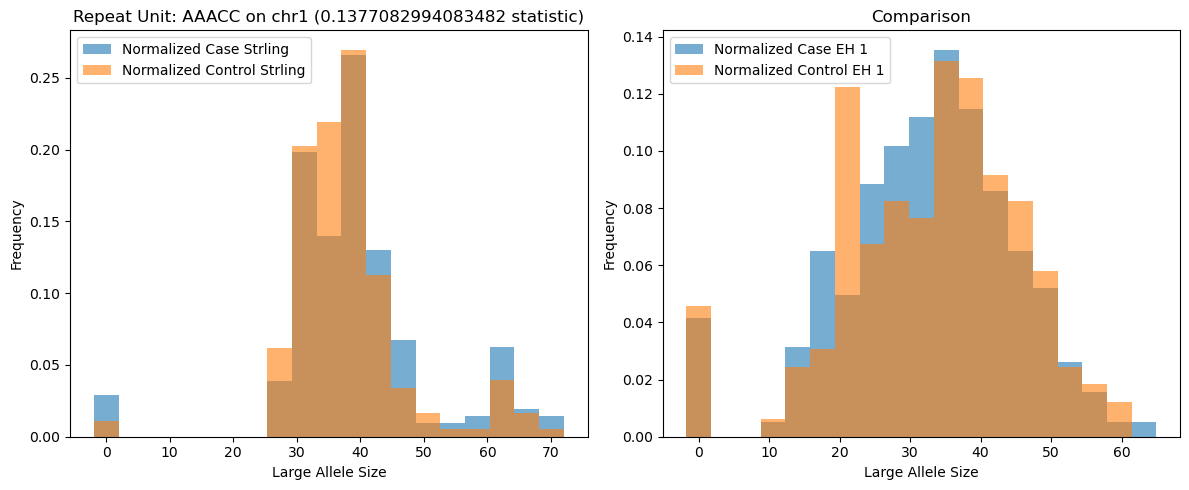

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Unnamed: 0                                                            8
chrom                                                              chr1
mean_left                                              152111747.458453
std_dev                                                       12.478972
variant                                              AGCAGCAGCTGAGGCGCG
statistic                                                      0.137708
p_value                                                         0.04682
case_values           [10, 19, 10, 0, 10, 8, 18, 18, 10, 0, 9, 12, 1...
control_values        [16, 18, 17, 10, 10, 11, 11, 10, 18, 8, 11, 9,...
recovered_variants                                                  349
actual_variants                                                   349.0
warning                                                           False
multi_expansions                                                      0
p_corrected                                                     

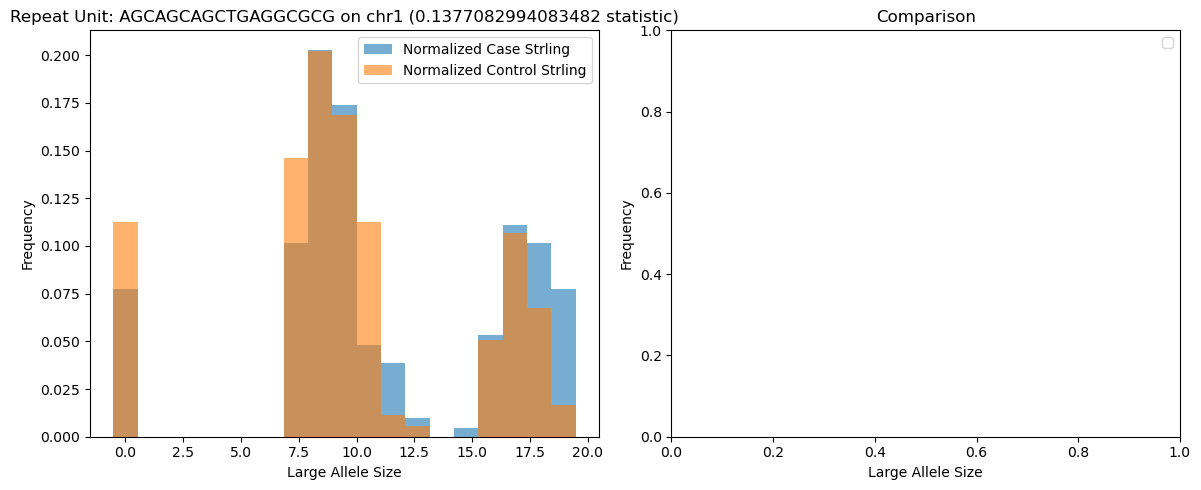

Unnamed: 0                                                           71
chrom                                                              chr1
mean_left                                               19061147.877604
std_dev                                                        2.398459
variant                                                             ACC
statistic                                                      0.127938
p_value                                                        0.077729
case_values           [66, 75, 63, 57, 80, 75, 61, 61, 77, 73, 72, 6...
control_values        [71, 69, 80, 76, 70, 56, 59, 71, 73, 75, 94, 5...
recovered_variants                                                  384
actual_variants                                                   384.0
warning                                                            True
multi_expansions                                                     10
p_corrected                                                     

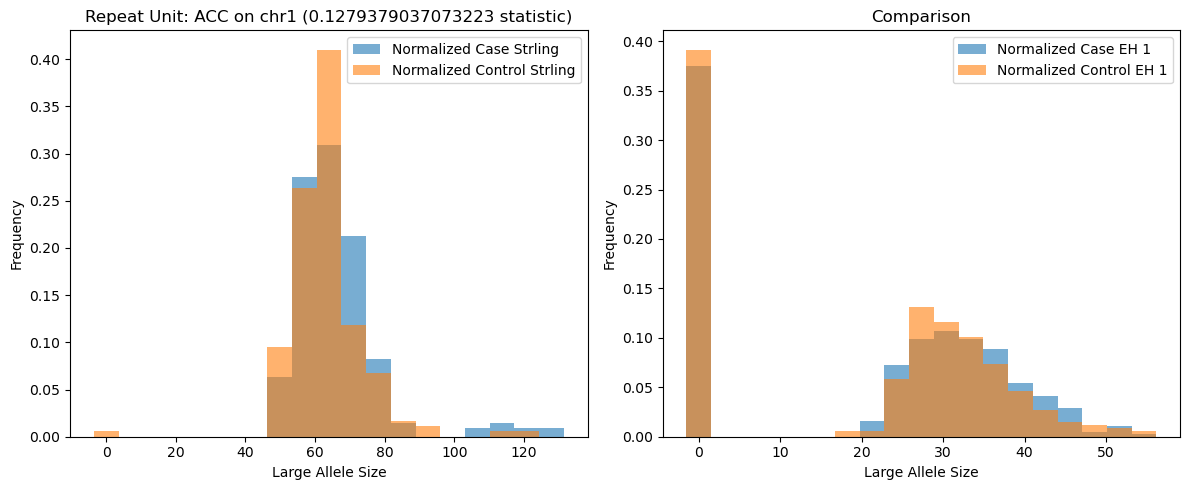

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Unnamed: 0                                                           44
chrom                                                              chr1
mean_left                                              242393142.584812
std_dev                                                        6.960292
variant                                                    ACTCATATATAT
statistic                                                      0.122754
p_value                                                        0.100324
case_values           [13, 15, 26, 0, 26, 13, 13, 28, 16, 13, 14, 0,...
control_values        [28, 15, 19, 15, 13, 0, 0, 26, 15, 17, 13, 23,...
recovered_variants                                                  338
actual_variants                                                   338.0
warning                                                           False
multi_expansions                                                      0
p_corrected                                                     

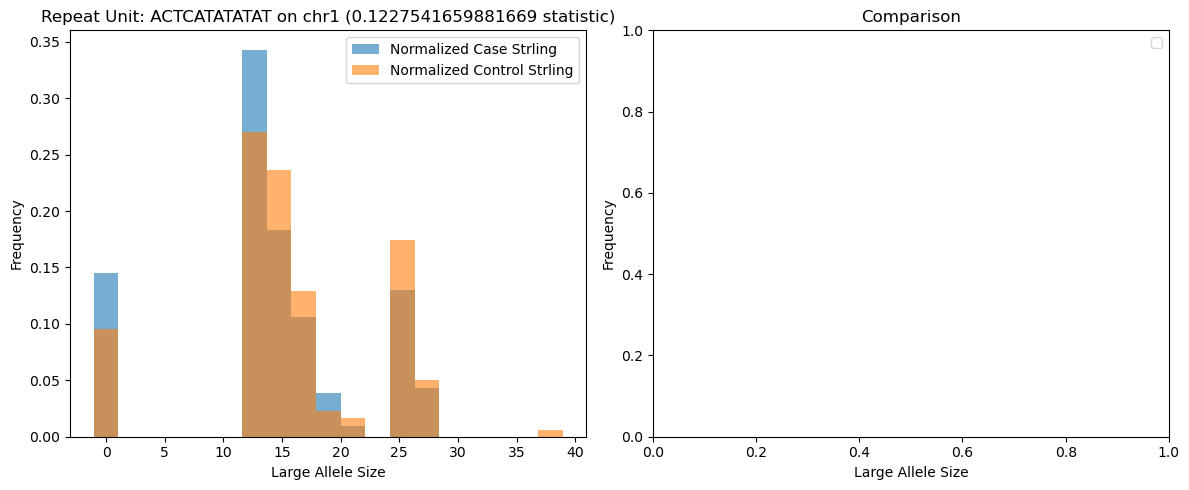

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Unnamed: 0                                                            6
chrom                                                              chr1
mean_left                                              152112058.165138
std_dev                                                       18.191469
variant                                              AGCAGCAGCGGAGGCGCG
statistic                                                      0.119063
p_value                                                        0.119305
case_values           [8, 0, 0, 0, 0, 0, 0, 9, 0, 8, 0, 8, 0, 0, 8, ...
control_values        [0, 8, 0, 0, 0, 8, 0, 8, 0, 0, 8, 0, 0, 0, 0, ...
recovered_variants                                                  109
actual_variants                                                   109.0
warning                                                           False
multi_expansions                                                      0
p_corrected                                                     

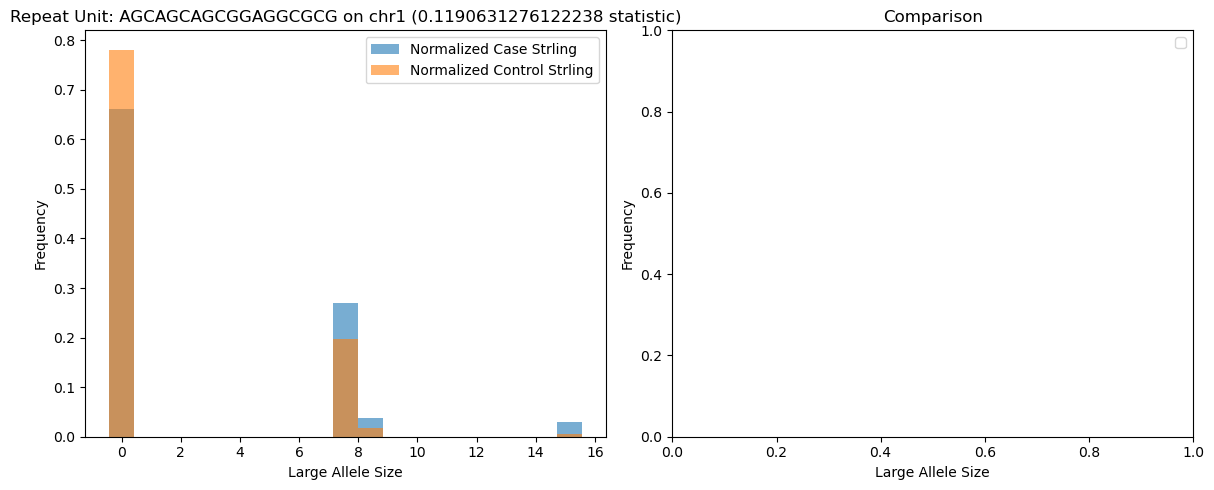

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Unnamed: 0                                                            3
chrom                                                              chr1
mean_left                                                3588541.226562
std_dev                                                        0.566449
variant                                                      AGGAGGGGGC
statistic                                                      0.115182
p_value                                                        0.142594
case_values           [22, 19, 16, 18, 19, 20, 22, 21, 23, 20, 23, 2...
control_values        [18, 21, 21, 27, 22, 18, 17, 23, 21, 24, 24, 2...
recovered_variants                                                  384
actual_variants                                                   384.0
warning                                                           False
multi_expansions                                                      0
p_corrected                                                     

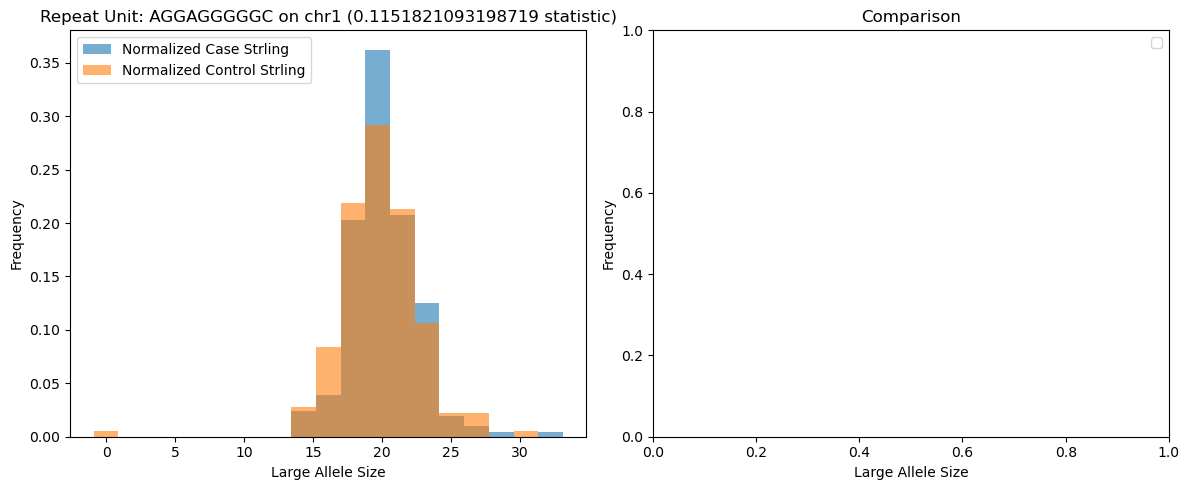

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Unnamed: 0                                                           37
chrom                                                              chr1
mean_left                                               30651878.977848
std_dev                                                        5.442473
variant                                             ACCTCCTCCCTGCCTGCTC
statistic                                                      0.114422
p_value                                                        0.147613
case_values           [8, 0, 0, 0, 8, 8, 0, 0, 0, 8, 0, 8, 8, 8, 0, ...
control_values        [0, 0, 8, 8, 0, 8, 0, 0, 0, 8, 8, 0, 0, 8, 0, ...
recovered_variants                                                  158
actual_variants                                                   158.0
warning                                                           False
multi_expansions                                                      0
p_corrected                                                     

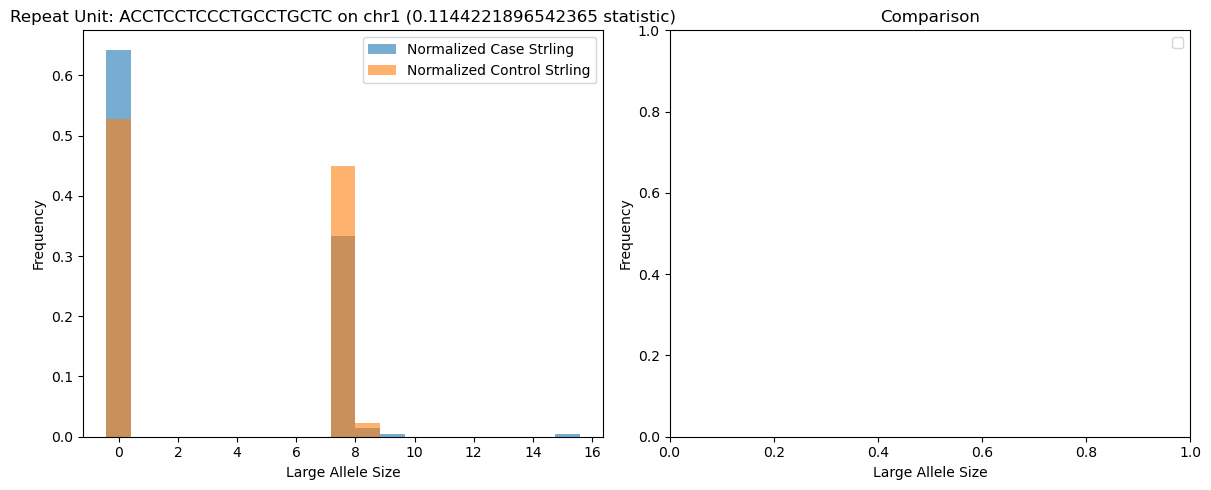

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Unnamed: 0                                                           49
chrom                                                              chr1
mean_left                                                11522712.30791
std_dev                                                       27.516303
variant                                                     ACCCAGCCAGG
statistic                                                      0.113201
p_value                                                        0.155852
case_values           [28, 14, 0, 15, 14, 0, 0, 0, 0, 0, 0, 14, 15, ...
control_values        [14, 0, 0, 0, 0, 0, 0, 0, 14, 0, 0, 0, 14, 14,...
recovered_variants                                                  177
actual_variants                                                   177.0
warning                                                           False
multi_expansions                                                      0
p_corrected                                                     

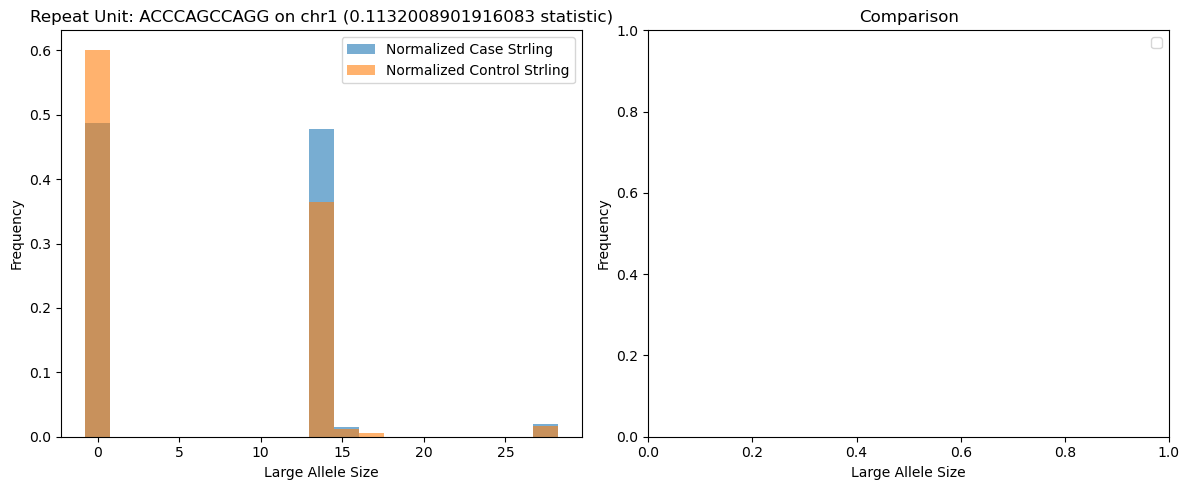

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Unnamed: 0                                                          124
chrom                                                              chr1
mean_left                                                  790064.58538
std_dev                                                       57.813841
variant                                                           AATGG
statistic                                                      0.111952
p_value                                                        0.164628
case_values           [0, 31, 31, 0, 32, 35, 63, 0, 93, 31, 31, 31, ...
control_values        [31, 0, 0, 31, 65, 0, 31, 31, 32, 64, 31, 33, ...
recovered_variants                                                  286
actual_variants                                                   285.0
warning                                                            True
multi_expansions                                                      8
p_corrected                                                     

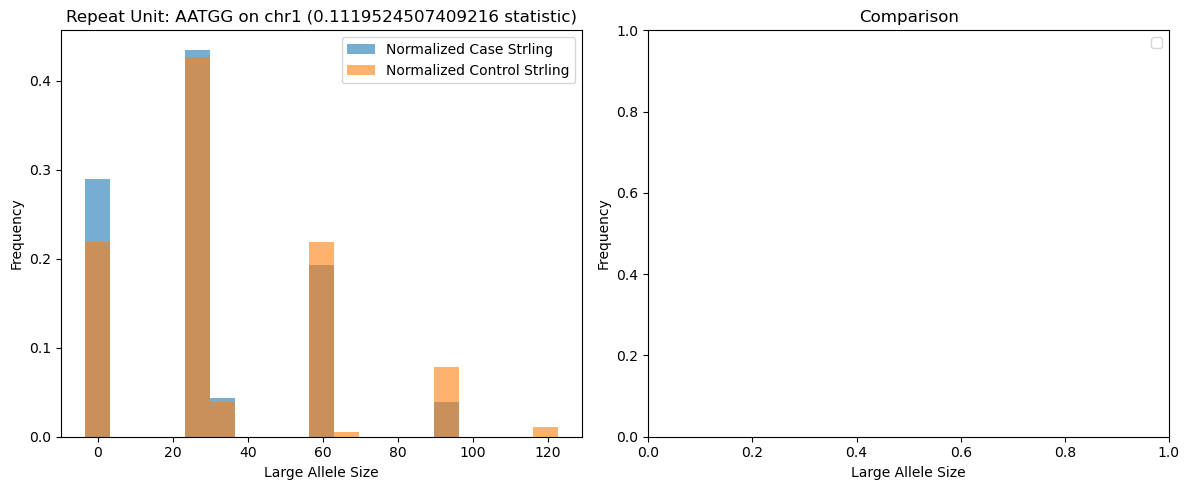

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Unnamed: 0                                                           63
chrom                                                              chr1
mean_left                                               19061209.718519
std_dev                                                        1.276222
variant                                              ACCACCACCACCACCATC
statistic                                                      0.110595
p_value                                                        0.174728
case_values           [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 0, 9, ...
control_values        [0, 8, 8, 0, 8, 8, 8, 0, 0, 0, 0, 8, 8, 0, 8, ...
recovered_variants                                                  135
actual_variants                                                   135.0
warning                                                           False
multi_expansions                                                      0
p_corrected                                                     

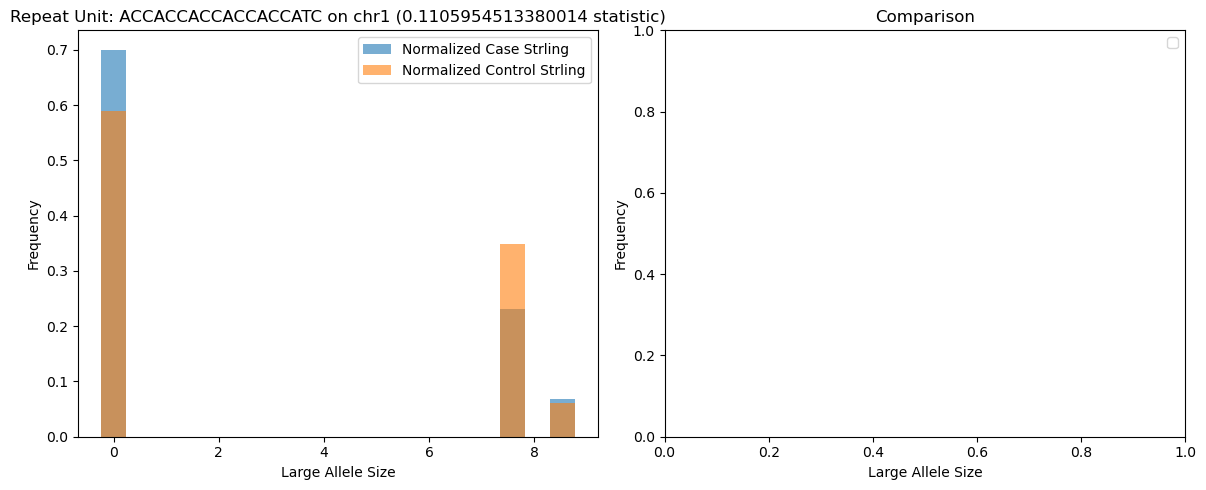

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Unnamed: 0                                                           26
chrom                                                              chr1
mean_left                                              212549615.471264
std_dev                                                       11.224139
variant                                                            AGGG
statistic                                                      0.104923
p_value                                                        0.221445
case_values           [0, 0, 0, 0, 0, 46, 0, 0, 0, 0, 0, 0, 41, 43, ...
control_values        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 39, 0, 42, 4...
recovered_variants                                                   87
actual_variants                                                    87.0
warning                                                           False
multi_expansions                                                      0
p_corrected                                                     

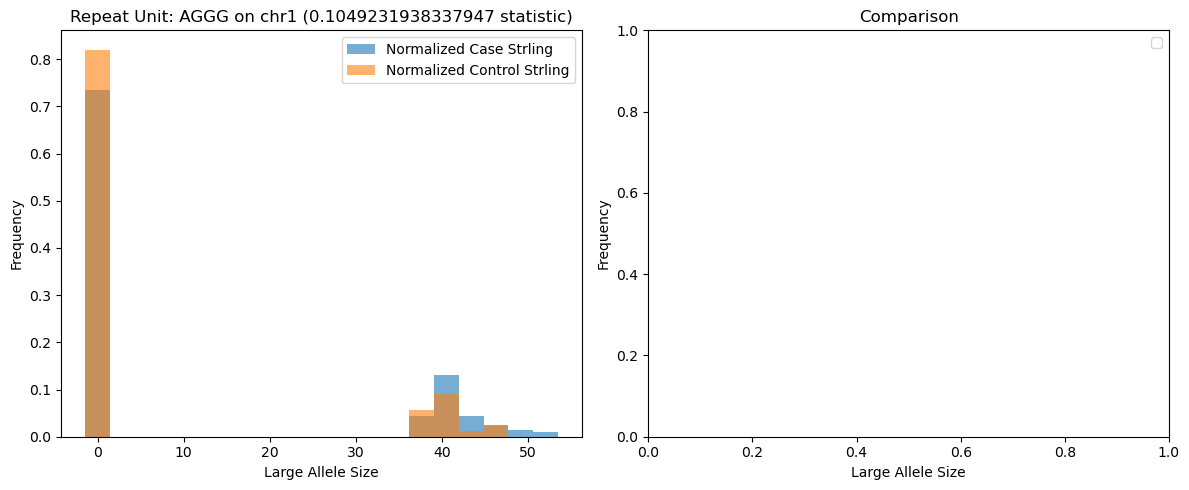

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Unnamed: 0                                                           25
chrom                                                              chr1
mean_left                                                2926713.766562
std_dev                                                       14.072681
variant                                                           AGCCC
statistic                                                      0.103648
p_value                                                        0.233494
case_values           [31, 31, 31, 31, 0, 31, 31, 0, 39, 33, 0, 31, ...
control_values        [0, 0, 32, 63, 34, 31, 34, 62, 63, 32, 33, 34,...
recovered_variants                                                  317
actual_variants                                                   317.0
warning                                                           False
multi_expansions                                                      0
p_corrected                                                     

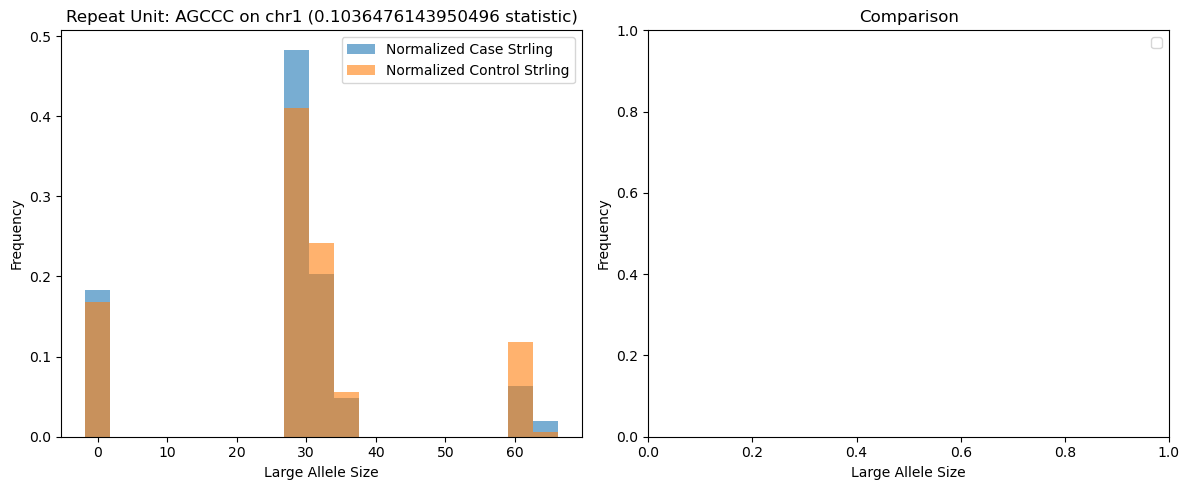

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Unnamed: 0                                                           99
chrom                                                              chr1
mean_left                                                5214353.284314
std_dev                                                       15.358244
variant                                               AATGTGTATATATATAT
statistic                                                      0.102779
p_value                                                        0.241632
case_values           [0, 19, 0, 0, 0, 9, 9, 0, 0, 9, 0, 0, 0, 11, 1...
control_values        [18, 9, 0, 18, 12, 10, 10, 11, 0, 0, 0, 0, 0, ...
recovered_variants                                                  204
actual_variants                                                   204.0
warning                                                           False
multi_expansions                                                      0
p_corrected                                                     

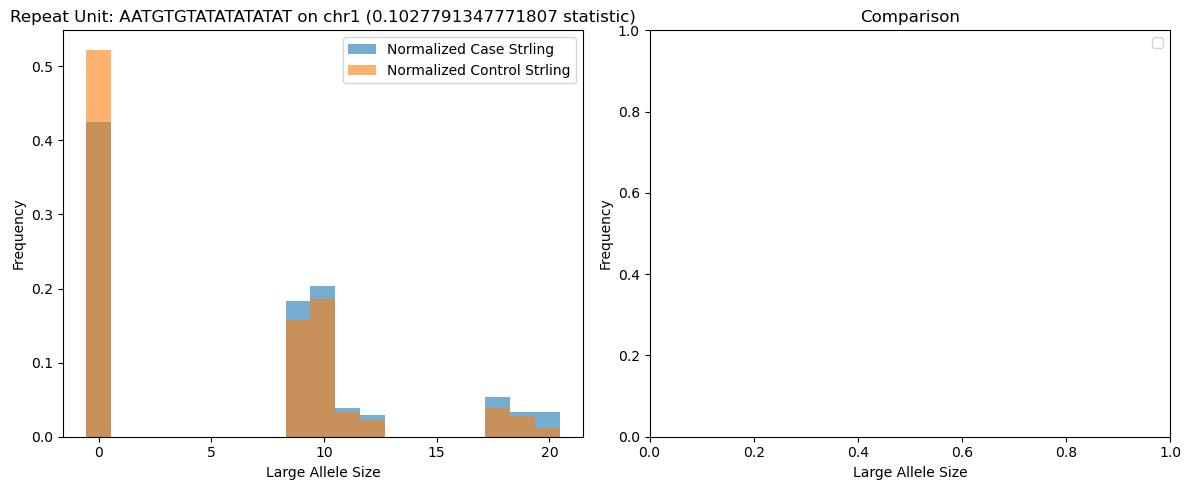

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Unnamed: 0                                                            2
chrom                                                              chr1
mean_left                                                3588624.540698
std_dev                                                        1.268592
variant                                            AGGAGGGGCCAGGAGGGGGC
statistic                                                      0.099495
p_value                                                        0.275163
case_values           [0, 7, 7, 7, 0, 0, 0, 7, 8, 0, 7, 8, 0, 0, 7, ...
control_values        [7, 0, 0, 7, 8, 0, 0, 8, 0, 7, 0, 0, 0, 7, 0, ...
recovered_variants                                                  172
actual_variants                                                   172.0
warning                                                           False
multi_expansions                                                      0
p_corrected                                                     

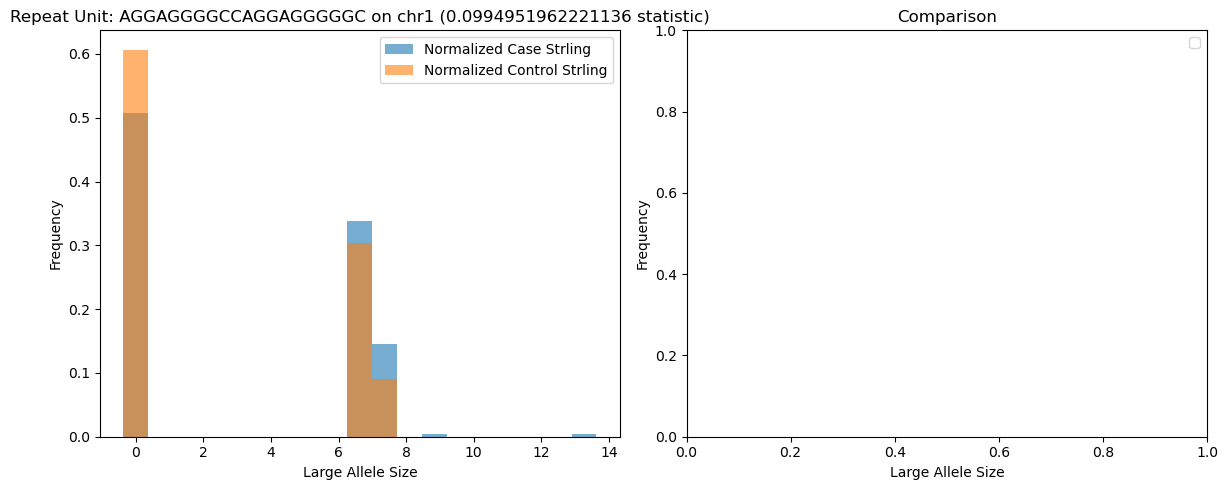

In [5]:
create_split_violin_plots_compare(ehdn_WT_df, strling_WT_df)